# RecDP LLM - rough score deduplication

Remove similar data by calculating the rough score. Using python library [rouge-score](https://pypi.org/project/rouge-score/)


### use case:
* Expect Input format: a folder of *.jsonl.
* Expect Output format: a folder of *.jsonl after reduction.


# Get started

## Install pyrecdp and dependencies

In [4]:
! DEBIAN_FRONTEND=noninteractive apt-get install -y openjdk-8-jre
! pip install pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jre is already the newest version (8u382-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


## 2. prepare your own data

In [5]:
%mkdir -p /content/test_data
%cd /content/test_data
file_names = ['tiny_c4_sample.jsonl']
file_list += [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/{i}" for i in file_names]
!wget -P /content/test_data {" ".join(file_list)}

/content/test_data
--2023-11-07 08:08:55--  https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/PILE/NIH_sample.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21626664 (21M) [text/plain]
Saving to: ‘/content/test_data/NIH_sample.jsonl’

NIH_sample.jsonl    100%[===================>]  20.62M  --.-KB/s    in 0.1s    

2023-11-07 08:08:55 (139 MB/s) - ‘/content/test_data/NIH_sample.jsonl’ saved [21626664/21626664]

--2023-11-07 08:08:55--  https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/tiny_c4_sample.jsonl
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1062126 (1.0M) [text/plain]
Saving to: ‘/content/test_data/tiny_c4_sample.jsonl’

tin

## 3. fuzzy deduplicate (seperate detection and reduction)

In [7]:
! ls /content/test_data

tiny_c4_sample.jsonl


### 3.1 PIPELINE based API

JAVA_HOME is not set, use default value of /usr/lib/jvm/java-8-openjdk-amd64/


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

2023-11-07 08:09:58.639 | WARNING  | pyrecdp.LLM.TextPipeline:enable_statistics:214 - Enabling this option will result in a decrease in execution speed


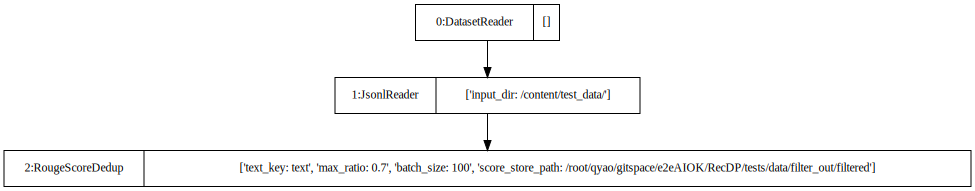

In [8]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = ResumableTextPipeline()
# optional to enable or not enable statistics.
# enable_statistics helps to show summary info
# not enable_statistics provides better performance
pipeline.enable_statistics()

# start to add ops to pipeline
ops = [
    JsonlReader("/content/test_data/"),
    RougeScoreDedup(text_key='text', max_ratio=0.7, batch_size=100),
]
pipeline.add_operations(ops)
pipeline.plot()

In [ ]:
ret = pipeline.execute()

[DatasetReader, PerfileSourcedJsonlReader, RougeScoreDedup, PerfileParquetWriter]
Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
execute with spark for global tasks started ...
DatasetReader
2023-11-07 08:10:12.814 | INFO     | pyrecdp.LLM.TextPipeline:execute:365 - DatasetReader: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.
execute with spark for global tasks took 0.004928010999947219 sec
PerfileSourcedJsonlReader


ResumableTextPipeline, current on tiny_c4_sample.jsonl:   0%|          | 0/1 [00:00<?, ?it/s]

tiny_c4_sample.jsonl
RougeScoreDedup


INFO:absl:Using default tokenizer.


2023-11-07 08:10:24.365 | INFO     | pyrecdp.primitives.operations.text_rouge_score_dedup:process_spark:101 - Round 0: processing 0 - 100
+--------------------+----+--------------------+----+-------+-----------+
|         instruction|id_1|       instruction_2|id_2|id_pair|rouge_score|
+--------------------+----+--------------------+----+-------+-----------+
|lorazepam nombre ...|   0|It is possible to...|   1|    0_1|0.072316386|
|lorazepam nombre ...|   0|It’s Day 11, and ...|  10|   0_10|0.099110544|
|Drake and Meek Mi...| 100|lorazepam nombre ...|   0|  0_100|0.051813472|
|French 75: gin, l...| 101|lorazepam nombre ...|   0|  0_101| 0.09227872|
|France Music Char...| 102|lorazepam nombre ...|   0|  0_102|0.032432433|
|Naughty office 3....| 103|lorazepam nombre ...|   0|  0_103|0.018126888|
|VoiPAY prepay pla...| 104|lorazepam nombre ...|   0|  0_104| 0.09255533|
|Here is the first...| 105|lorazepam nombre ...|   0|  0_105|0.050704226|
|For anyone seekin...| 106|lorazepam nombre ...|

In [ ]:
pipeline.plot()

In [ ]:
del pipeline